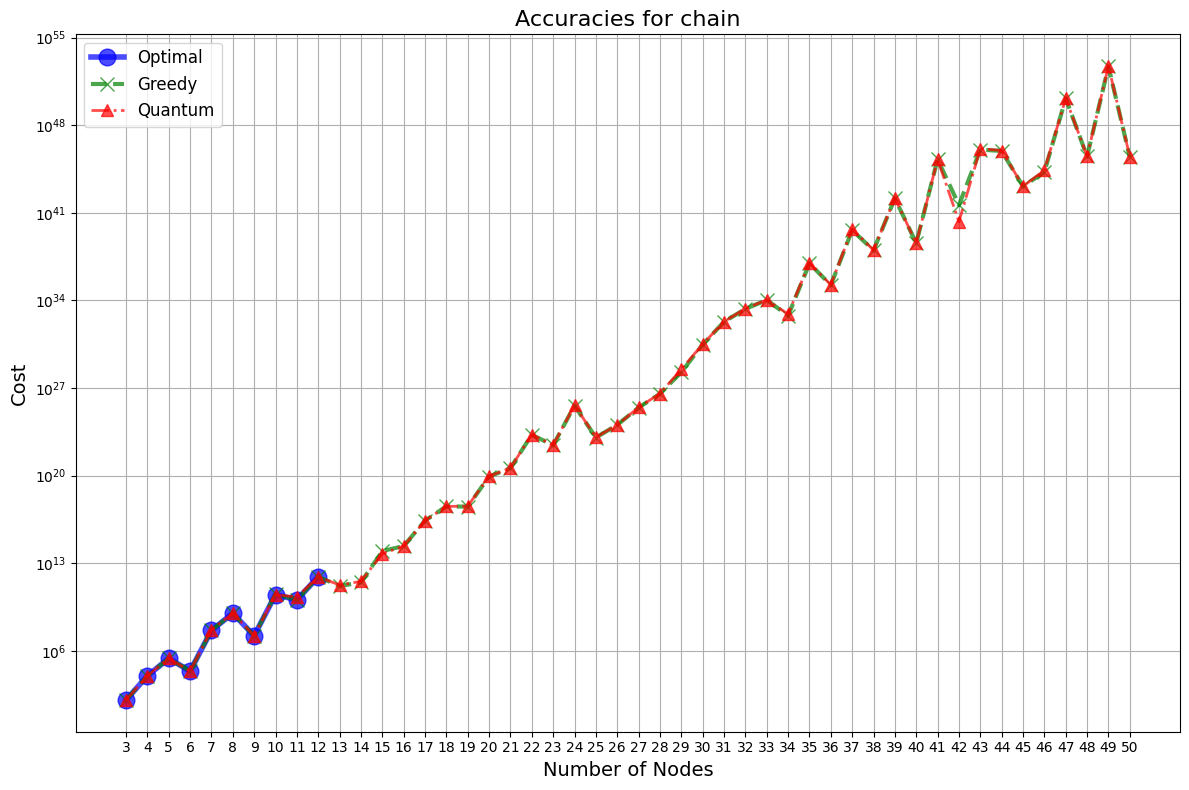

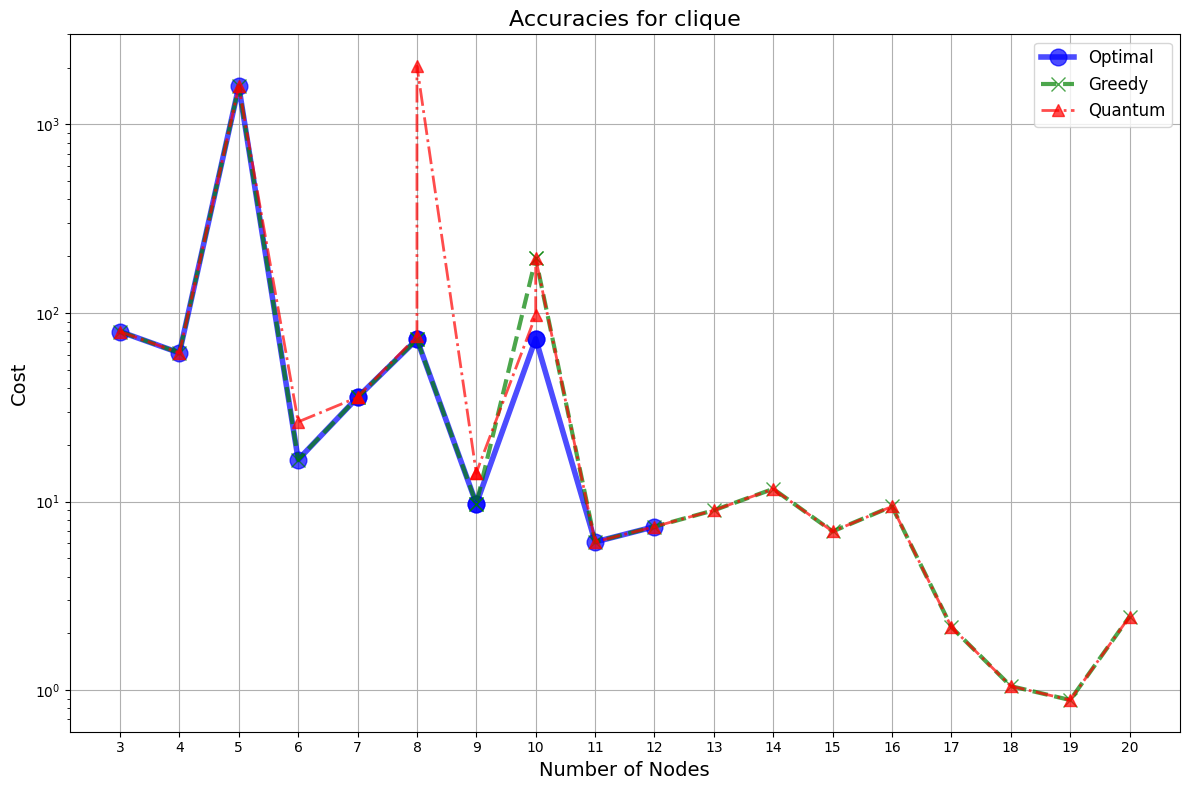

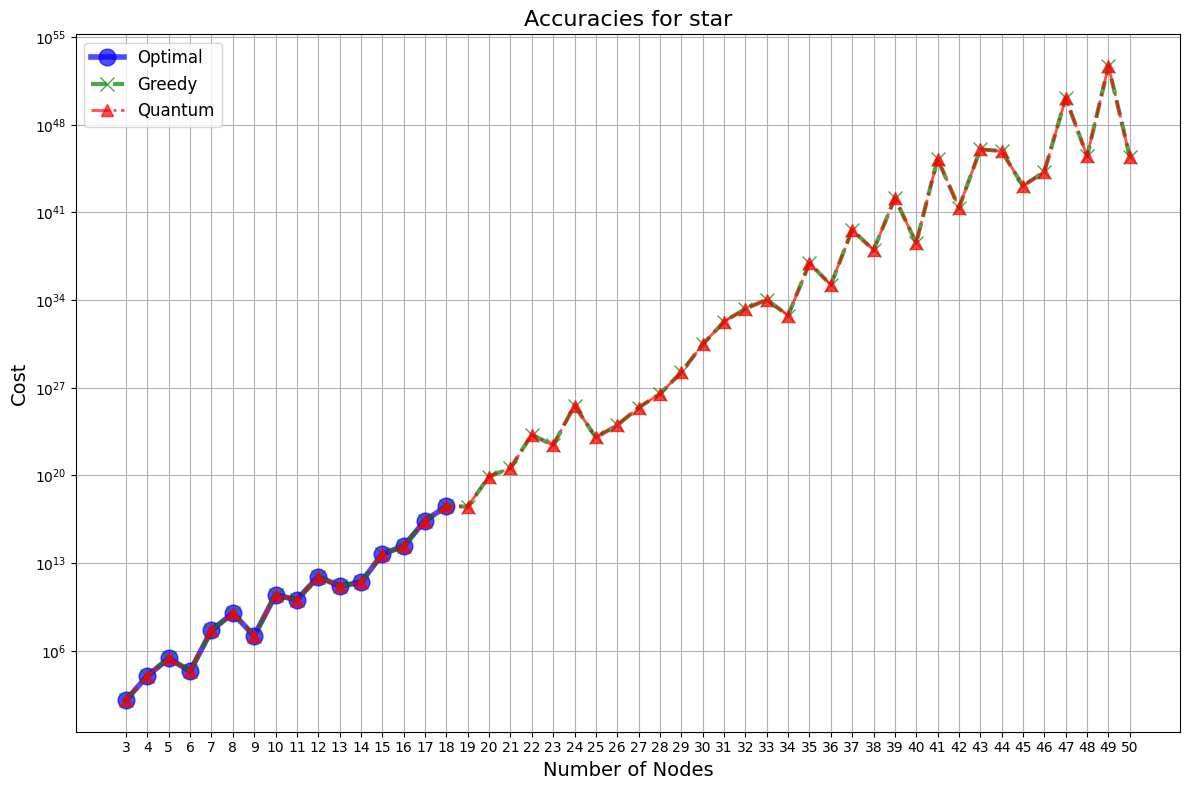

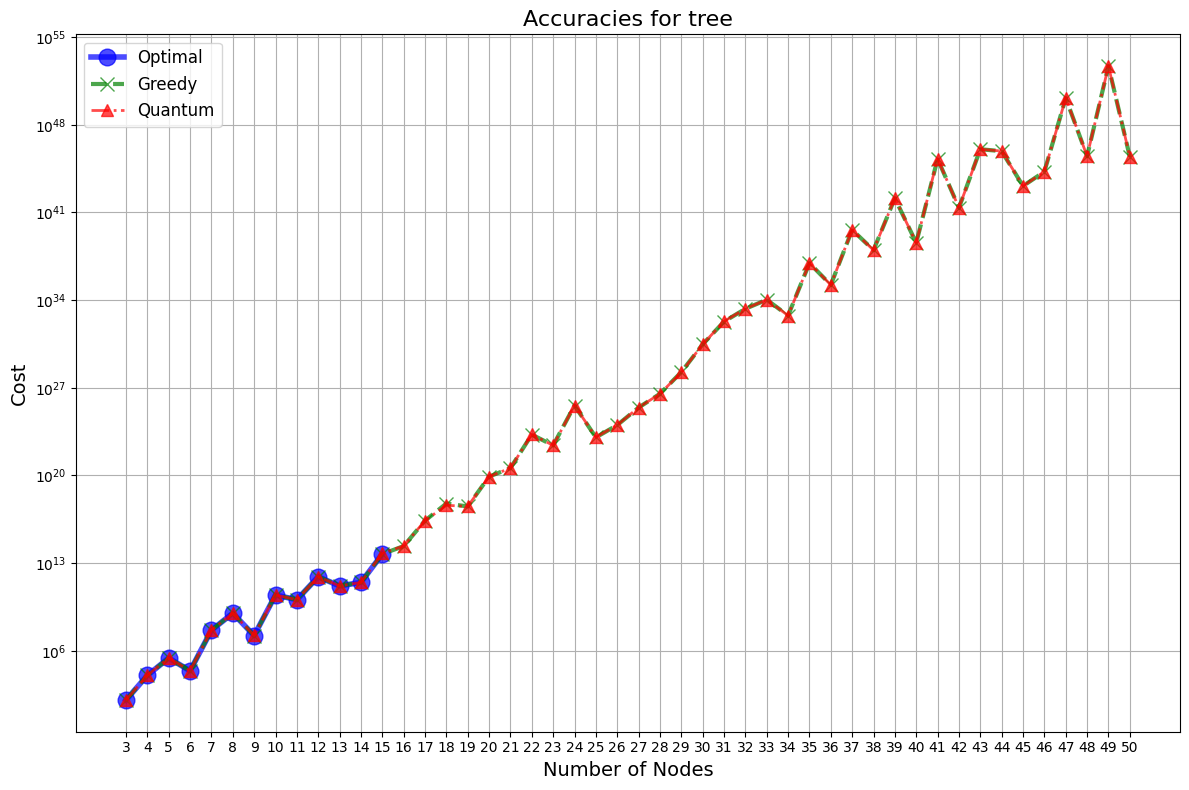

In [4]:
import os
import json
import matplotlib.pyplot as plt
from collections import defaultdict

def load_json_files(folder_path):
    json_files = []
    for filename in os.listdir(folder_path):
        if filename.endswith(".json"):
            with open(os.path.join(folder_path, filename), 'r') as file:
                data = json.load(file)
                json_files.append((filename, data))
    return json_files

def parse_filename(filename):
    parts = filename.split('_')
    graph_type = parts[1]
    num_nodes = int(parts[2])
    return graph_type, num_nodes

def extract_data(json_files):
    data = defaultdict(lambda: {'optimal': [], 'greedy': [], 'quantum': [], 'nodes': []})
    
    for filename, content in json_files:
        graph_type, num_nodes = parse_filename(filename)
        content = list(content.values())[0]
        if content:
            if 'optimal_cost' in content:
                data[graph_type]['optimal'].append(content['optimal_cost'])
            if 'greedy_cost' in content:
                data[graph_type]['greedy'].append(content['greedy_cost'])
            if 'cost' in content:
                data[graph_type]['quantum'].append(content['cost'])
            data[graph_type]['nodes'].append(num_nodes)
    
    # For each graph type, sort the data by number of nodes
    for graph_type, values in data.items():
        sort_order = sorted(range(len(values['nodes'])), key=lambda k: values['nodes'][k])
        for key in values.keys():
            values[key] = [values[key][i] for i in sort_order]
    
    return data

def plot_accuracies(data):
    line_styles = ['-', '--', '-.', ':']
    markers = ['o', 'x', '^', 's']
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
    markersizes = [12, 10, 8]
    linewidths = [4, 3, 2]

    for graph_type, values in data.items():
        fig, ax = plt.figure(figsize=(12, 8))
        smoke_gray = '#eaeaea'
        ax.set_facecolor(smoke_gray)
        
        for i, (key, line_style, marker) in enumerate(zip(['optimal', 'greedy', 'quantum'], line_styles, markers)):
            if values[key]:
                plt.plot(
                    values['nodes'], 
                    values[key], 
                    label=key.capitalize(), 
                    linestyle=line_style, 
                    marker=marker, 
                    color=colors[i % len(colors)],
                    linewidth=linewidths[i % len(linewidths)],
                    markersize=markersizes[i % len(markersizes)],
                    alpha=0.7
                )
        
        plt.title(f'Accuracies for {graph_type}', fontsize=16)
        plt.xlabel('Number of Nodes', fontsize=14)
        
        x_ticks = range(min(values['nodes']), max(values['nodes']) + 1)
        plt.xticks(x_ticks)
        
        plt.ylabel('Cost', fontsize=14)
        plt.yscale('log')
        plt.legend(fontsize=12)
        plt.grid(True)
        plt.tight_layout()
        plt.savefig(f'figures/{graph_type}_accuracies.png')
        #plt.show()

# Main execution
folder_path = '..\\results\\heuristic_1\\gurobi'  # Replace with your folder path
json_files = load_json_files(folder_path)
data = extract_data(json_files)
plot_accuracies(data)
